캐글의 Global Wheat Detection 의 코드 중 하나인 
object detection - tensorflow end to end 의 코드

I entered this competition as an opportunity to implement an object detection model, something I know how to do in theory but have not yet put into practice. As yolo is the model I am most familiar with I will be implementing a model inspired by yolov3 (though not exactly the same) using Tensorflow.

In [16]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

# Load Data
I'll begin by loading the labels data and extracting the bounding boxes (which I refer to as "bboxes" in the code) from the table.

In [17]:
# 현재 working directory 확인
import os
os.getcwd()

'C:\\Users\\cheer\\DL'

In [18]:
labels = pd.read_csv('C://Users/cheer/DL/Kaggle_Wheat_Data/train.csv')
labels.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [19]:
type(labels['bbox'][0])  # bbox 안의 list의 type 확인하기

str

In [20]:
type(labels['bbox'])  # bbox 데이터가 Series인지 Data Frame인지 확인하기

pandas.core.series.Series

# 여기서 나오는 group['bbox'] 혹은 boundaries는 각 bounding box의 인덱스, 그리고 bbox 데이터이다 

## bounding box 갯수 확인 방법

In [21]:
print(len(labels['bbox']))  # 데이터의 크기 확인

147793


위 데이터를 보면 Image_id에 bounding box가 list 형태로 여러 개가 존재 -> 이걸 image_id로 검색할 수 있도록 묶는 과정이 필요 
47번째 행부터 b6ab77fd7 에서 b53afdf5c로 바뀌는 걸 볼 수 있음

In the raw data each bounding box is in an array of length 4 but formatted as a string. The below block of code groups the bounding boxes by image id and places the bounding boxes as numpy arrays next to each image id. The image id can then be used to quickly retrieve all of the bounding boxes.

-> 각 bounding box의 길이는 4 but string으로 돼있음 / 아래의 코드로 bounding box를 이미지ID로 묶고, bounding box를 numpy 배열로 각 이미지ID에 둘 예정 // 
이미지ID는 bounding box를 빠르게 검색할 수 있을 것임

In [22]:
# 각 bounding box를 묶는 함수
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)  
    # bbox 열의 bounding box 데이터를 쉼표를 기준으로 구분
    # expand = True -> 분리 결과를 list로 변환하는 과정 없이 DataFrame으로 바로 받을 수 있다.
    boundaries[0] = boundaries[0].str.slice(start=1) # 1번 index부터 끝까지 잘라서 냄기기 
    boundaries[3] = boundaries[3].str.slice(stop=-1) # -1번 index까지 잘라서 냄기기
     # boundaries가 '[333','20', '1324', 'ㅇㅇㅇ]' 식으로 돼있어서 
    # index 0번과 -1번이 각각 '[' ']' 이다. 
    # 그래서 각 데이터 숫자를 분리하기 위해서 양 끝단의 boundaries 값들을 선택해서 slice한 것 
    return boundaries.values.astype(float)
    # 아직 string 형태인 bbox를 float로 바꾼 것

labels = labels.groupby('image_id').apply(group_boxes)

## Image 갯수 확인 방법

In [9]:
print(len(labels))

3373


With the labels extracted from the data I now need the images loaded as numpy arrays. At this point it is worth splitting the data into a training and validation dataset. As the dataset is small I will keep the vast majority of the images in the training dataset and only put the last ten images aside as a validation dataset. This may not be the best size to perform accurate validation but I think it is the right compromise considering the number of images available and the complexity of the task.

-> 데이터에서 추출된 labels를 사용하여 이미지를 numpy array 형태로 load 해야함
이 때, dataset을 train data와 validation data로 나눠야 함
dataset이 작기 때문에, train 데이터를 많이 주고, 뒤의 10개 이미지만 validation data로 설정 할거임
이러한 설정이 validation에 좋지 않을 수 있지만, 이미지 데이터의 갯수와 task의 복잡성을 생각하면 괜찮은 타협이라고 생각함

In [10]:
print(labels.index)

Index(['00333207f', '005b0d8bb', '006a994f7', '00764ad5d', '00b5fefed',
       '00b70a919', '00e903abe', '00ea5e5ee', '010b216d4', '010c93b99',
       ...
       'ff46aa8d4', 'ff5c9104a', 'ff86547fb', 'ffaa964a2', 'ffb0f6eca',
       'ffb445410', 'ffbf75e5b', 'ffbfe7cc0', 'ffc870198', 'ffdf83e42'],
      dtype='object', name='image_id', length=3373)


In [23]:
# numpy.unique(): np 배열의 모든 고유 값을 검색하고, 이러한 고유 값들을 정렬
train_image_ids = np.unique(labels.index.values)[0:3363]
# .index -> pandas로 읽은 dataset의 index 반환
# .values -> 해당 index 값들을 Numpy array로 반환
val_image_ids = np.unique(labels.index.values)[3363:3373]

With the ids split it's now time to load the images. To keep the training of the model relatively fast I will resize each image from (1024,1024) to (256,256). I experimented with larger images and with the model I am using I didn't see a good enough lift in training accuracy to make up for the extra time it took to train a model with larger images.

-> 이미지 ID 별로 나눴으니, 모델의 훈련 속도를 비교적 빠르게 하기 위해서 이미지 사이즈를 (1024, 1024) 에서 (256, 256)으로 resize할 것임 
더 큰 사이즈의 이미지로 실험해보긴 했는데, 소요된 시간들 만큼의 train accuracy가 향상되지는 않았음

In [24]:
# Image는 Pillow 패키지에 속함
# from PIL import Image로 쓰면 됨

def load_image(image_id):
    image = Image.open('C://Users/cheer/DL/Kaggle_Wheat_Data/train/' + image_id + ".jpg")
    # Image.open('file_path')
    imgae = image.resize((256, 256))
    # Image resize(size, resample = 0)
    # size - 변경 후 크기(픽셀)을 (width, height) 튜플로 지정
    # resample - 리샘플링 필터를 지정
    
    return np.asarray(image) # 튜플로 된 것을 ndarray로 변환

1. numpy.asarray는 입력을 numpy array로 변환하는데 사용되기도 함 

2. numpy의 array와 asarray는 numpy 배열로 같지만 array는 기본적으로 copy = True를 같고(객체의 복사본을 생성), asarray는 copy = False다.(생성하지 않음) / asarray는 ndarray의 data type이 설정 돼있다면, 데이터 형태가 다를 경우에만 복사가 된다. 

# tqdm
## tqdm means "progress" in Arabic(taqadum)
tqdm은 파이썬에서 쓰이는 진행 상황 표시 모듈 / for문과 같은 반복문에서 사용하여 현재 상태를 시각화 및 진행률, 소요시간 표시
tqdm은 기본적으로 순회 가능한 객체(List, Tuple, Iterator 등)의 진행 상황을 표시 할 수 있음
### 파라미터
 - desc: 진행 상호아 표시줄의 제목 / default = None
 - total: 진행 상황을 100%로 표시하기 위한 전체 작업 수 설정 / default = None / 작업 수를 모륵면 자동으로 결정됨
 - leave: 진행 상호아 표시줄이 작업이 완료된 후에도 표시될지(True) 결정 / default = True
 - file: 진행 상황을 출력할 파일을 설정 / default = stderr / stdout 등 다른 파일ㅇ르 설정 할 수 있음

In [25]:
# train pixel 과 labels 딕셔너리 생성
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id) # 이미지 로드
    train_labels[image_id] = labels[image_id].copy() / 4

  0%|          | 0/3363 [00:00<?, ?it/s]

In [26]:
# validation pixels와 labels 딕셔너리 생성
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)
    val_labels[image_id] = labels[image_id].copy() / 4

  0%|          | 0/10 [00:00<?, ?it/s]

# Visualise Images
Before going on it is worth having a look at some of the images and bounding boxes in the dataset. For that a few helper functions will be required. The below functions take an image id and the corresponding bounding boxes and return the bounding boxes drawn onto the image.

-> 계속 진행가기 전에, dataset 안의 bounding box와 몇몇 이미지를 봐야한다. 
그러기 위해서는 몇 가지 도움이 되는 function들이 필요하다
아래의 function들은 이미지ID와 bounding box들을 가져오고, bounding box가 그려진 이미지를 return 한다.

In [27]:
def draw_bboxes(image_id, bboxes, source = 'train'):
    image = Image.open('C://Users/cheer/DL/Kaggle_Wheat_Data/' + source + '/' + image_id + ".jpg")
    image = image.resize((256, 256))
    
    draw = ImageDraw.Draw(image)
    
    for bbox in bboxes:
        draw_bbox(draw, bbox)
        
    return np.asarray(image)
    

def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width = 2, outline = 'red')

I'll also add a wrapper function to call this function multiple times for multiple images.

-> 여러 이미지에 대해 위 함수가 여러 번 실행되기 위해 wrapper function을 구현하겠다

In [28]:
def show_images(image_ids, bboxes, source = 'train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(draw_bboxes(image_id, bboxes[image_id], source))
        
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(1, num_of_images,
                            figsize = (5 * num_of_images, 5 * num_of_images)
                            )
                      
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

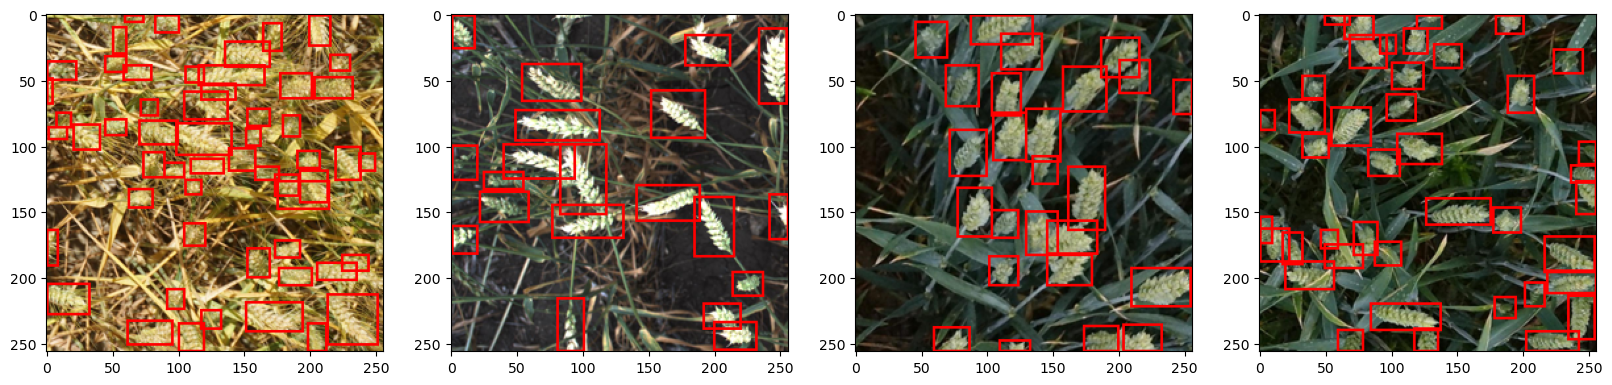

In [29]:
show_images(train_image_ids[0:4], train_labels)

# Clean bounding boxes
There are a small number of bounding boxes in this dataset that do not bound a head of wheat. While the number is small enough that the model can still learn how to detect the heads of wheat they still cause a little bit of inaccuracy. Below I'll search for tiny bounding boxes that cannot possibly fit a head of wheat inside them and huge bounding boxes that miss the head of wheat they are aimed at.

-> 이 dataset에는 wheat 하나를 bound하지 않는 bbox가 몇 개 있다. 모델이 wheat를 detect하기에는 충분할 정도로 적은 수긴 하지만, 이로 인해 약간의 inaccuracy를 일으킬 수 있다.

여기부터는 wheat를 포함하지 않는 작은 bbox 를 찾아낼 것이고, wheat를 target하지 못하는 큰 bbox를 찾아낼 것이다. 


In [30]:
tiny_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] <= 10 and label[2] * label[3] != 0:
            tiny_bboxes.append(i)

print(f"{len(tiny_bboxes)} tiny bounding boxes found")

50 tiny bounding boxes found


In [31]:
huge_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] > 8000:
            huge_bboxes.append(1)
            
            
print(f"{len(huge_bboxes)} huge bounding boxes found")

13 huge bounding boxes found


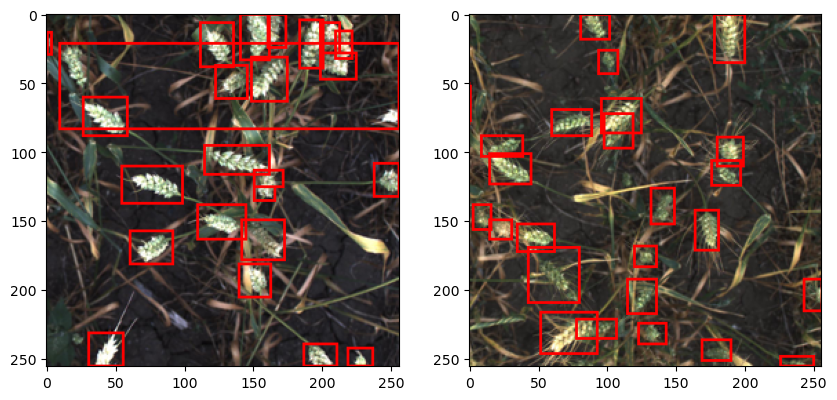

In [56]:
show_images(train_image_ids[562:564], train_labels)

I did some more manual inspection of the bad labels picked out of this code that I have not included in this notebook. I found that some huge bounding boxes were actually okay as they bound a very zoomed in image. To this end I have listed a few to be kept (1079, 1371, 2020). Otherwise the below code throws out any bounding boxes whose area is larger than 8000 or smaller than 5.

-> 